<a href="https://colab.research.google.com/github/ratul442/American-Express-Data-Analysis/blob/main/American_Express_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# American Express Machine Learning Hackathon

American Express hosted a machine learning hackathon (https://datahack.analyticsvidhya.com/contest/american-express-amexpert-2018/). We have provided by data of clickstream of 6 days from 2 July 2017 to 7 July 2017. We have to predict depending upon the data whether a session will result in a click or not.

In [82]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

Setting up your project directory 

Loading the train data

In [83]:
train_df = pd.read_csv("/content/train.csv")

In [84]:
train_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [85]:
train_df.describe()

,session_id,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,age_level,user_depth,city_development_index,var_1,is_click
count,463291.000000,4.632910e+05,463291.000000,463291.000000,463291.000000,97437.000000,445048.000000,445048.000000,445048.000000,338162.000000,463291.000000,463291.000000
mean,285544.090725,5.460497e+05,308474.540069,29685.878994,3.072427,162753.345105,3.477396,2.782266,2.878415,2.557121,0.422169,0.067627
std,168577.345887,3.294625e+05,126517.101294,21542.053106,1.304233,78743.742720,2.412889,1.069701,0.400130,0.921345,0.493906,0.251105
min,2.000000,4.000000e+00,82320.000000,1734.000000,1.000000,18595.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,137856.500000,2.578550e+05,118601.000000,13787.000000,2.000000,82527.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000
50%,285429.000000,5.318010e+05,359520.000000,13787.000000,3.000000,146115.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
75%,435535.500000,8.278490e+05,405490.000000,53587.000000,4.000000,254132.000000,4.000000,3.000000,3.000000,3.000000,1.000000,0.000000
max,595812.000000,1.141729e+06,414149.000000,60305.000000,5.000000,450184.000000,12.000000,6.000000,3.000000,4.000000,1.000000,1.000000


In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
session_id                463291 non-null int64
DateTime                  463291 non-null object
user_id                   463291 non-null int64
product                   463291 non-null object
campaign_id               463291 non-null int64
webpage_id                463291 non-null int64
product_category_1        463291 non-null int64
product_category_2        97437 non-null float64
user_group_id             445048 non-null float64
gender                    445048 non-null object
age_level                 445048 non-null float64
user_depth                445048 non-null float64
city_development_index    338162 non-null float64
var_1                     463291 non-null int64
is_click                  463291 non-null int64
dtypes: float64(5), int64(7), object(3)
memory usage: 53.0+ MB


In [87]:
train_df.shape

(463291, 15)

The train data has 15 variables and 463291 observations. 

In [88]:
train_df.groupby('is_click')['session_id'].count()

is_click
0    431960
1     31331
Name: session_id, dtype: int64

###### We have imbalance target class 
We need to use upscalling technique's or gradient boosting technique's

## Missing Value Analysis
The list below determines the percentage of observation missing in every variable.

In [89]:
missing_data = (((train_df.isnull().sum())*100)/len(train_df))
missing_data

session_id                 0.000000
DateTime                   0.000000
user_id                    0.000000
product                    0.000000
campaign_id                0.000000
webpage_id                 0.000000
product_category_1         0.000000
product_category_2        78.968510
user_group_id              3.937698
gender                     3.937698
age_level                  3.937698
user_depth                 3.937698
city_development_index    27.008727
var_1                      0.000000
is_click                   0.000000
dtype: float64

#### Remove all observations where gender is missing
since we have more than one values missing in those observations.

In [90]:
train_df = train_df[train_df['gender'].notnull()]

######  Analysing product_category_2 : 
Delete Product Category since missing values % > 30%

In [91]:
train_df = train_df.drop(['product_category_2'], axis = 1)


###### Analysing Development Index :
No pattern found so we'll delete all observation having is_click = 0 and impute median having is_click = 1

In [92]:
train_df = train_df[-((train_df['city_development_index'].isnull()) & (train_df['is_click'] == 0))]

In [93]:
train_df.shape

(345370, 14)

In [94]:
missing_data = (((train_df.isnull().sum())*100)/len(train_df))
missing_data

session_id                0.000000
DateTime                  0.000000
user_id                   0.000000
product                   0.000000
campaign_id               0.000000
webpage_id                0.000000
product_category_1        0.000000
user_group_id             0.000000
gender                    0.000000
age_level                 0.000000
user_depth                0.000000
city_development_index    2.087037
var_1                     0.000000
is_click                  0.000000
dtype: float64

###### Imputing 'city_development_index'
Imputing it with median

In [95]:
train_df['city_development_index'].loc[train_df['city_development_index'].isnull()]= 2.0

In [96]:
missing_data = (((train_df.isnull().sum())*100)/len(train_df))
missing_data

session_id                0.0
DateTime                  0.0
user_id                   0.0
product                   0.0
campaign_id               0.0
webpage_id                0.0
product_category_1        0.0
user_group_id             0.0
gender                    0.0
age_level                 0.0
user_depth                0.0
city_development_index    0.0
var_1                     0.0
is_click                  0.0
dtype: float64

###### All missing values have been taken care of

# Outlier Analysis 
Do Outlier Analysis after Upscaling

In [97]:
cnames = []
catnames = []
for i in train_df.columns:
    if train_df[i].dtype == 'float64' or train_df[i].dtype == 'int64':
        cnames.append(i)
    
    if train_df[i].dtype == 'object':
        catnames.append(i)

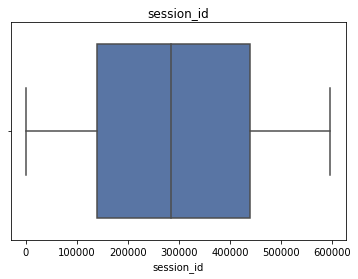

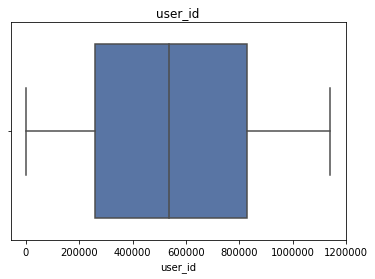

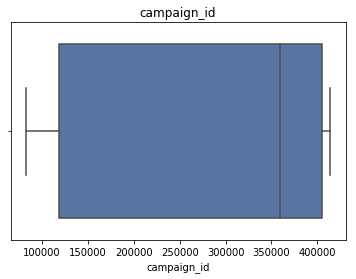

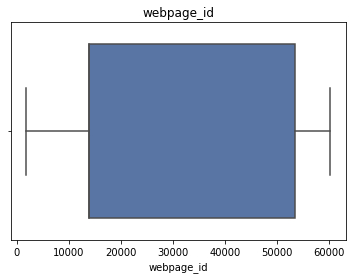

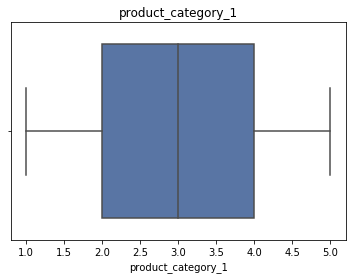

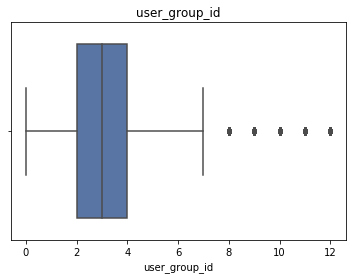

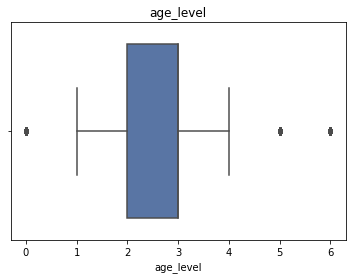

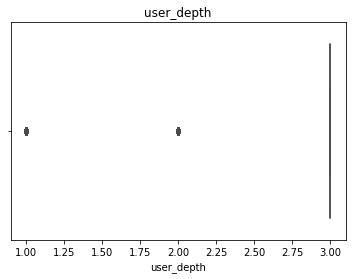

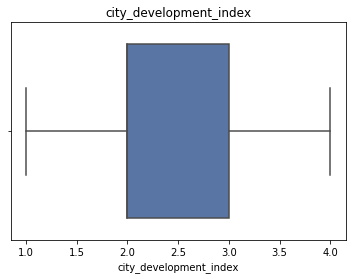

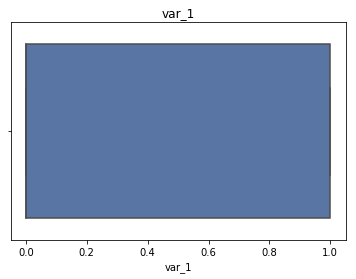

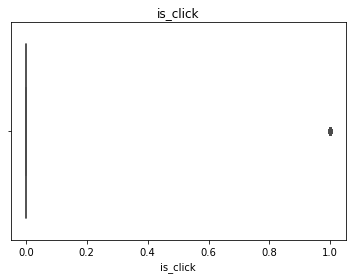

In [98]:
# #Plotting Box Plot
for i in cnames:
    plt.figure()
    plt.clf() #clearing the figure
    sns.boxplot(train_df[i],palette="deep")
    plt.title(i)
    plt.show()

###### Since we have an imbalance in target class, We'll do the outlier analysis later after upscaling.

## Feature Selection

#### Correlation Plot 

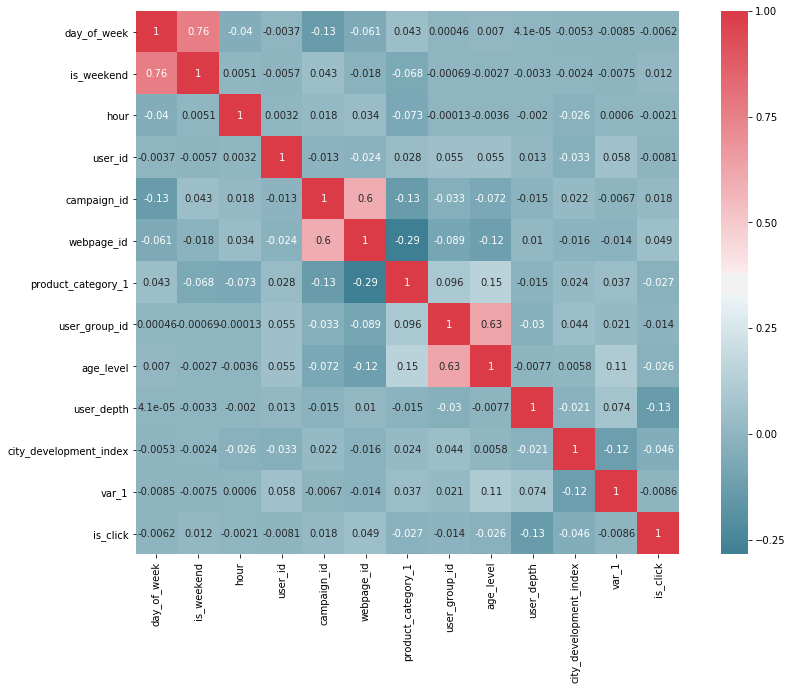

In [175]:
#Set the width and hieght of the plot
df_corr = train_df.loc[:,cnames]

f, ax = plt.subplots(figsize=(15, 10))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot = True)

###### Correlation Matrix does'nt shows any significance correlation between the variables.

In [100]:
#loop for chi square values
for i in catnames:
    print(i)
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(train_df['is_click'], train_df[i]))
    print(p)

DateTime
1.8982190908263574e-08
product
1.4920498213715828e-63
gender
0.05592863701141619


###### Chi2 test for categoric variables
since the gender pvalue is >0.05 we'll drop gender variable since it doesn't contributes much

In [101]:
train_df = train_df.drop(['gender'], axis = 1)


## Feature Engineering
Feature Engineering DataTime Column. Since the data is only for 6 days over which the year and month is same we will replace the column with the below mentioned columns:

1. day_of_the_week
2. is_holiday
3. hour

In [102]:
from datetime import datetime
 
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M" ).weekday()
train_df['day_of_week'] = train_df['DateTime'].map(day_of_week)
train_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1,is_click,day_of_week
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,10.0,4.0,3.0,3.0,0,0,6
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,3.0,3.0,3.0,2.0,1,0,6
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,2.0,2.0,3.0,2.0,1,0,6
6,17583,2017-07-02 00:01,1091463,F,405490,60305,3,9.0,3.0,3.0,4.0,0,0,6
7,461128,2017-07-02 00:01,469098,C,360936,13787,3,4.0,4.0,3.0,4.0,0,0,6


In [103]:
time = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M").time()
train_df['time'] = train_df['DateTime'].map(time)
train_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1,is_click,day_of_week,time
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,10.0,4.0,3.0,3.0,0,0,6,00:00:00
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,3.0,3.0,3.0,2.0,1,0,6,00:00:00
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,2.0,2.0,3.0,2.0,1,0,6,00:01:00
6,17583,2017-07-02 00:01,1091463,F,405490,60305,3,9.0,3.0,3.0,4.0,0,0,6,00:01:00
7,461128,2017-07-02 00:01,469098,C,360936,13787,3,4.0,4.0,3.0,4.0,0,0,6,00:01:00


In [104]:
#function  to return wether it's a weekday or weekend
def is_weekend(x):
    if x['day_of_week'] < 5 :
        return 0 
    else:
        return 1

In [105]:
train_df['is_weekend'] = train_df.apply(lambda row: is_weekend(row),axis=1)

#### Coverting Time into Hour Clusters
Figuring out in which hours was maxim clicks done


Initialising seperate dataframe to understand the relation between 'is_click' and 'hour'

In [106]:
click_by_time = pd.DataFrame(train_df.groupby('time')['is_click'].sum())

In [107]:
click_by_time = click_by_time.reset_index()
click_by_time.head()

,time,is_click
0,00:00:00,2
1,00:01:00,1
2,00:02:00,8
3,00:03:00,0
4,00:04:00,3


Extracting the hour from time column of click_by_time dataframe

In [108]:
click_by_time['time'] = pd.to_datetime(click_by_time['time'], format="%H:%M:%S")
click_by_time['click_hour'] = click_by_time.time.dt.hour

Converting time column back to object and only keeping time values

In [109]:
click_by_time['time'] = click_by_time.time.dt.strftime('%H:%M:%S')

In [110]:
click_by_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
time          1440 non-null object
is_click      1440 non-null int64
click_hour    1440 non-null int64
dtypes: int64(2), object(1)
memory usage: 33.8+ KB


In [111]:
click_by_time.groupby('click_hour')['is_click'].sum()

click_hour
0      143
1      113
2       75
3      299
4      576
5      966
6     1458
7     1737
8     1734
9     1686
10    1974
11    1837
12    1656
13    1596
14    1630
15    1433
16    1393
17    1444
18    1706
19    2093
20    2282
21    1426
22     551
23     249
Name: is_click, dtype: int64

In [112]:
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'], format="%Y-%m-%d %H:%M")
train_df['hour'] = train_df.DateTime.dt.hour

In [113]:
train_df = train_df[['DateTime','day_of_week','is_weekend','hour','user_id','product','campaign_id','webpage_id','product_category_1','user_group_id','age_level','user_depth',
                     'city_development_index','var_1','is_click',]]

In [114]:
cnames = []
catnames = []
for i in train_df.columns:
    if train_df[i].dtype == 'float64' or train_df[i].dtype == 'int64':
        cnames.append(i)
    
    if train_df[i].dtype == 'object':
        catnames.append(i)

In [115]:
train_df = train_df.drop(['DateTime'], axis = 1)

## Model Development

In [116]:
X = train_df.iloc[:, 0:13].values
y = train_df.iloc[:, 13].values

In [117]:
X

array([[6, 1, 0, ..., 3.0, 3.0, 0],
       [6, 1, 0, ..., 3.0, 2.0, 1],
       [6, 1, 0, ..., 3.0, 2.0, 1],
       ...,
       [4, 0, 23, ..., 3.0, 2.0, 0],
       [4, 0, 23, ..., 3.0, 2.0, 1],
       [4, 0, 23, ..., 3.0, 4.0, 0]], dtype=object)

In [118]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 4] = labelencoder_X_1.fit_transform(X[:, 4])

onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]
X

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 1.,  6.,  0., ...,  3.,  3.,  0.],
       [ 1.,  6.,  0., ...,  3.,  2.,  1.],
       [ 1.,  6.,  0., ...,  3.,  2.,  1.],
       ...,
       [ 0.,  4., 23., ...,  3.,  2.,  0.],
       [ 0.,  4., 23., ...,  3.,  2.,  1.],
       [ 0.,  4., 23., ...,  3.,  4.,  0.]])

In [119]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting XGBoost to the Training set
import xgboost
classifier = xgboost.XGBClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()

0.0003752242931181148

In [120]:
accuracies.std()

0.0003752242931181148

In [121]:
accuracies.mean()

0.9156520587016288

# Predicting the final output

In [160]:
test = pd.read_csv("/content/test.csv")

In [122]:
test_df = pd.read_csv('/content/test.csv')

In [123]:
test_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1
0,411705,2017-07-08 00:00,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0
1,208263,2017-07-08 00:00,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1
2,239450,2017-07-08 00:00,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1
3,547761,2017-07-08 00:00,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0
4,574275,2017-07-08 00:00,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1


### Making the same features as training dataset

In [124]:
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M" ).weekday()
test_df['day_of_week'] = test_df['DateTime'].map(day_of_week)
test_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,day_of_week
0,411705,2017-07-08 00:00,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0,5
1,208263,2017-07-08 00:00,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1,5
2,239450,2017-07-08 00:00,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1,5
3,547761,2017-07-08 00:00,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0,5
4,574275,2017-07-08 00:00,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1,5


In [125]:
def is_weekend(x):
    if x['day_of_week'] < 5 :
        return 0 
    else:
        return 1

In [126]:
test_df['is_weekend'] = test_df.apply(lambda row: is_weekend(row),axis=1)

In [127]:
test_df['time'] = pd.to_datetime(test_df['DateTime'], format="%Y-%m-%d %H:%M")
test_df['hour'] = test_df.time.dt.hour

In [128]:
test_df = test_df.drop(['DateTime','session_id'], axis = 1)

## Missing Value Analysis

In [129]:
missing_data = (((test_df.isnull().sum())*100)/len(train_df))
missing_data

user_id                    0.000000
product                    0.000000
campaign_id                0.000000
webpage_id                 0.000000
product_category_1         0.000000
product_category_2        22.054898
user_group_id              1.645771
gender                     1.645771
age_level                  1.645771
user_depth                 1.645771
city_development_index    10.020847
var_1                      0.000000
day_of_week                0.000000
is_weekend                 0.000000
time                       0.000000
hour                       0.000000
dtype: float64

In [130]:
test_df = test_df[test_df['age_level'].notnull()]

In [131]:
test_df['city_development_index'].loc[test_df['city_development_index'].isnull()]= 2.0

## Rearranging the testdata

In [132]:
test_df = test_df[['day_of_week','is_weekend','hour','user_id','product','campaign_id','webpage_id','product_category_1','user_group_id','age_level','user_depth',
                     'city_development_index','var_1']]

In [133]:
test_df.head()

,day_of_week,is_weekend,hour,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1
0,5,1,0,732573,J,404347,53587,1,5.0,5.0,3.0,2.0,0
3,5,1,0,557318,G,118601,28529,5,1.0,1.0,3.0,1.0,0
4,5,1,0,923896,H,118601,28529,5,9.0,3.0,1.0,2.0,1
5,5,1,0,854182,I,118601,28529,4,1.0,1.0,3.0,4.0,1
6,5,1,0,1101628,D,118601,28529,4,2.0,2.0,3.0,2.0,1


## Producing the final output

In [134]:
X = train_df.iloc[:, 0:13].values

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 4] = labelencoder_X_1.fit_transform(X[:, 4])

onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [141]:
test_df.head()

,day_of_week,is_weekend,hour,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1
0,5,1,0,732573,J,404347,53587,1,5.0,5.0,3.0,2.0,0
3,5,1,0,557318,G,118601,28529,5,1.0,1.0,3.0,1.0,0
4,5,1,0,923896,H,118601,28529,5,9.0,3.0,1.0,2.0,1
5,5,1,0,854182,I,118601,28529,4,1.0,1.0,3.0,4.0,1
6,5,1,0,1101628,D,118601,28529,4,2.0,2.0,3.0,2.0,1


In [156]:
output = classifier.predict(X)
output

array([0, 0, 0, ..., 0, 0, 0])

In [159]:
train_df.head(1)

,day_of_week,is_weekend,hour,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1,is_click
0,6,1,0,858557,C,359520,13787,4,10.0,4.0,3.0,3.0,0,0


In [167]:
test

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1
0,411705,2017-07-08 00:00,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0
1,208263,2017-07-08 00:00,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1
2,239450,2017-07-08 00:00,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1
3,547761,2017-07-08 00:00,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0
4,574275,2017-07-08 00:00,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1
5,394913,2017-07-08 00:00,854182,I,118601,28529,4,82527.0,1.0,Male,1.0,3.0,4.0,1
6,562747,2017-07-08 00:00,1101628,D,118601,28529,4,82527.0,2.0,Male,2.0,3.0,2.0,1
7,224359,2017-07-08 00:00,1101628,D,118601,28529,5,82527.0,2.0,Male,2.0,3.0,2.0,1
8,395004,2017-07-08 00:00,1088284,I,118601,28529,4,82527.0,2.0,Male,2.0,3.0,1.0,0
9,572855,2017-07-08 00:00,972585,H,118601,28529,5,82527.0,2.0,Male,2.0,3.0,2.0,0


In [172]:
final = pd.DataFrame(test['session_id'], output).reset_index()

In [173]:
final.to_csv("result_amex.csv")